In [606]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [607]:
df = pd.read_csv(".\chronic_kidney_disease_full.csv")
seed = 84

# Change column name to make it easier since 'class' is pre-defined
df['class'].unique()
df.rename(columns={'class': 'class_label'}, inplace=True)

In [608]:
df.shape

(400, 25)

In [609]:
# see unique values of columns
for column in df.columns:
    print(column + ": ")
    print(eval("df."+ column + ".unique()"))
    print("\n")

age: 
['48' '7' '62' '51' '60' '68' '24' '52' '53' '50' '63' '40' '47' '61' '21'
 '42' '75' '69' '?' '73' '70' '65' '76' '72' '82' '46' '45' '35' '54' '11'
 '59' '67' '15' '55' '44' '26' '64' '56' '5' '74' '38' '58' '71' '34' '17'
 '12' '43' '41' '57' '8' '39' '66' '81' '14' '27' '83' '30' '4' '3' '6'
 '32' '80' '49' '90' '78' '19' '2' '33' '36' '37' '23' '25' '20' '29' '28'
 '22' '79']


bp: 
['80' '50' '70' '90' '?' '100' '60' '110' '140' '180' '120']


sg: 
['1.02' '1.01' '1.005' '1.015' '?' '1.025']


al: 
['1' '4' '2' '3' '0' '?' '5']


su: 
['0' '3' '4' '1' '?' '2' '5']


rbc: 
['?' 'normal' 'abnormal']


pc: 
['normal' 'abnormal' '?']


pcc: 
['notpresent' 'present' '?']


ba: 
['notpresent' 'present' '?']


bgr: 
['121' '?' '423' '117' '106' '74' '100' '410' '138' '70' '490' '380' '208'
 '98' '157' '76' '99' '114' '263' '173' '95' '108' '156' '264' '123' '93'
 '107' '159' '140' '171' '270' '92' '137' '204' '79' '207' '124' '144'
 '91' '162' '246' '253' '141' '182' '86' '150' '1

In [610]:
# There exists some unclear type
df.replace('?', np.nan, inplace=True)
df.replace('\t','', regex=True, inplace=True)
df.reset_index(inplace=True)
df = df.drop('index', axis = 1)

# Encode categorical data with binary
df['dm'] = df['dm'].str.strip()
df[['htn','dm','cad','pe','ane']] = df[['htn','dm','cad','pe','ane']].replace(to_replace={'yes': 1,'no': 0})
df[['rbc','pc']] = df[['rbc','pc']].replace(to_replace={'abnormal': 1,'normal': 0})
df[['pcc','ba']] = df[['pcc','ba']].replace(to_replace={'present': 1,'notpresent': 0})
df[['appet']] = df[['appet']].replace(to_replace={'good': 1,'poor': 0})

# change data type from object to float - due to na values, can't cast into integer
df[['age','bp', 'sg', 'al', 'su', 'sc', 'sod', 'dm', 'pot', 'hemo', 'bgr','bu',
    'pcv', 'wbcc', 'rbcc']] = df[['age','bp', 'sg', 'al', 'su', 'sc', 'sod','dm', 'pot', 'hemo', 'bgr','bu', 'pcv', 'wbcc', 'rbcc']].astype('Float64')


# Change class labels into binary
df['class_label'] = df['class_label'].apply(lambda x: 1 if x == "ckd" else 0) 
df['class_label'].value_counts()

1    250
0    150
Name: class_label, dtype: int64

In [612]:
# Filling out missing values with mean
fill_col_list = ['age', 'bp', 'sg', 'bgr', 'bu', 'sc', 'sod', 'hemo', 'pcv', 'wbcc', 'rbcc']
for col in fill_col_list:
#     print(df[col])
    df[col].fillna(df[col].mean(), inplace = True)

df.dropna(inplace= True)

In [613]:
df.shape

(254, 24)

In [614]:
df['class_label'].value_counts()

0    129
1    125
Name: class_label, dtype: int64

Cross Validation Process

In [615]:
labels = np.array(df['class_label'])
df= df.drop('class_label', axis = 1)

df_list = list(df.columns)

train_x, test_x, train_y, test_y = train_test_split(df, labels, test_size = 0.3, random_state = seed)

print ("Train_x Shape: ",train_x.shape)
print ("Train_y Shape: ", train_y.shape)
print ("Test_x Shape: ", test_x.shape)
print ("Test_y Shape: ", test_y.shape)

Train_x Shape:  (177, 23)
Train_y Shape:  (177,)
Test_x Shape:  (77, 23)
Test_y Shape:  (77,)


In [617]:
clf = DecisionTreeClassifier()
bgc = BaggingClassifier(random_state=seed)
rfc = RandomForestClassifier(random_state=seed)
abc = AdaBoostClassifier(random_state=seed)
sgb = GradientBoostingClassifier(random_state=seed)

Approach 1: CV as Stratified, K = 5. Best one is Gradient Boosting

In [644]:
clf_cv_score = cross_val_score(clf, df, labels, cv=5, scoring='accuracy')
print("Mean Accuracy Score - DTR: ", clf_cv_score.mean())

bgc_cv_score = cross_val_score(bgc, df, labels, cv=5, scoring='accuracy')
print("Mean Accuracy Score - BAG: ", bgc_cv_score.mean())

rfc_cv_score = cross_val_score(rfc, df, labels, cv=5, scoring='accuracy')
print("Mean Accuracy Score - RFC: ", rfc_cv_score.mean())

abc_cv_score = cross_val_score(abc, df, labels, cv=5, scoring='accuracy')
print("Mean Accuracy Score - ADA: ", abc_cv_score.mean())

sgb_cv_score = cross_val_score(sgb, df, labels, cv=5, scoring='accuracy')
print("Mean Accuracy Score - GBC: ", sgb_cv_score.mean())


Mean Accuracy Score - DTR:  0.9921568627450981
Mean Accuracy Score - BAG:  0.9723921568627452
Mean Accuracy Score - RFC:  0.976392156862745
Mean Accuracy Score - ADA:  0.9803137254901962
Mean Accuracy Score - GBC:  0.9921568627450981


Approach 2: CV as KFold, K = 5. Best one is Gradient Boosting

In [645]:
clf_cv_score = cross_val_score(clf, df, labels, cv=KFold(5), scoring='accuracy')
print("Mean Accuracy Score - DTR: ", clf_cv_score.mean())

bgc_cv_score = cross_val_score(bgc, df, labels, cv=KFold(5), scoring='accuracy')
print("Mean Accuracy Score - BAG: ", bgc_cv_score.mean())

rfc_cv_score = cross_val_score(rfc, df, labels, cv=KFold(5), scoring='accuracy')
print("Mean Accuracy Score - RFC: ", rfc_cv_score.mean())

abc_cv_score = cross_val_score(abc, df, labels, cv=KFold(5), scoring='accuracy')
print("Mean Accuracy Score - ADA: ", abc_cv_score.mean())

sgb_cv_score = cross_val_score(sgb, df, labels, cv=KFold(5), scoring='accuracy')
print("Mean Accuracy Score - GBC: ", sgb_cv_score.mean())

Mean Accuracy Score - DTR:  0.9882352941176471
Mean Accuracy Score - BAG:  0.9724705882352943
Mean Accuracy Score - RFC:  0.9803921568627452
Mean Accuracy Score - ADA:  0.9803921568627452
Mean Accuracy Score - GBC:  0.9882352941176471


Approach 3: CV as KFold, K = 5. Best one is Gradient Boosting, 
scoring method is different from others. I used make_scorer for a sanity check.


In [646]:
from sklearn.metrics.scorer import make_scorer
scorer=make_scorer(accuracy_score, greater_is_better=True)

clf_cv_score = cross_val_score(clf, df, labels, cv=KFold(5), scoring=scorer)
print("Mean Accuracy Score - DTR: ", clf_cv_score.mean())

bgc_cv_score = cross_val_score(bgc, df, labels, cv=KFold(5), scoring=scorer)
print("Mean Accuracy Score - BAG: ", bgc_cv_score.mean())

rfc_cv_score = cross_val_score(rfc, df, labels, cv=KFold(5), scoring=scorer)
print("Mean Accuracy Score - RFC: ", rfc_cv_score.mean())

abc_cv_score = cross_val_score(abc, df, labels, cv=KFold(5), scoring=scorer)
print("Mean Accuracy Score - ADA: ", abc_cv_score.mean())

sgb_cv_score = cross_val_score(sgb, df, labels, cv=KFold(5), scoring=scorer)
print("Mean Accuracy Score - GBC: ", sgb_cv_score.mean())

Mean Accuracy Score - DTR:  0.9882352941176471
Mean Accuracy Score - BAG:  0.9724705882352943
Mean Accuracy Score - RFC:  0.9803921568627452
Mean Accuracy Score - ADA:  0.9803921568627452
Mean Accuracy Score - GBC:  0.9882352941176471


Gradient Boosting is selected from the cross validation process.

In [647]:
# Define parameters
params = {
        'n_estimators': list(np.linspace(10, 300, 10, dtype = int)),
        'learning_rate': [0.01, 0.05, 0.1, 0.15],
        'max_depth': [3, 4, 5, 6, 7],
    'random_state': [seed],
    'max_features': [10, 15, 20]
        }

In [648]:
gbm = GradientBoostingClassifier()
model = RandomizedSearchCV(estimator=gbm, param_distributions = params, scoring='accuracy', n_iter = 20,
                              cv = 5 , n_jobs = -1)

model.fit(train_x,train_y)


print("Random")

trainypred1 = model.best_estimator_.predict(train_x)
print ("Accuracy Score Train:", metrics.accuracy_score(train_y, trainypred1))

y_pred9 = model.best_estimator_.predict(test_x)

print(confusion_matrix(test_y, y_pred9))
print("Accuracy:",metrics.accuracy_score(test_y, y_pred9))

print(model.best_params_)

Random
Accuracy Score Train: 1.0
[[39  0]
 [ 1 37]]
Accuracy: 0.987012987012987
{'random_state': 84, 'n_estimators': 300, 'max_features': 15, 'max_depth': 3, 'learning_rate': 0.15}


In [649]:
print("Grid")
grid_search = {
    'max_depth': [model.best_params_['max_depth'] - 1,
                  model.best_params_['max_depth'],
                  model.best_params_['max_depth'] + 1],
    'learning_rate': [model.best_params_['learning_rate'] - 0.01,
                      model.best_params_['learning_rate'],
                      model.best_params_['learning_rate'] + 0.01],
     'max_features': [model.best_params_['max_features'] - 2,
                      model.best_params_['max_features'],
                      model.best_params_['max_features'] + 2],
    'n_estimators': [model.best_params_['n_estimators'] - 10, 
                     model.best_params_['n_estimators'], 
                     model.best_params_['n_estimators'] + 10]
}

clf = GradientBoostingClassifier()
model = GridSearchCV(estimator = clf, param_grid = grid_search, 
                               cv = 5, scoring='accuracy', n_jobs = -1)
model.fit(train_x, train_y)

trainypred2 = model.best_estimator_.predict(train_x)
print ("Accuracy Score Train:", metrics.accuracy_score(train_y, trainypred2))

y_pred10 = model.best_estimator_.predict(test_x)

print(confusion_matrix(test_y, y_pred10))
print("Accuracy:",metrics.accuracy_score(test_y, y_pred10))

print(model.best_params_)

Grid
Accuracy Score Train: 1.0
[[39  0]
 [ 0 38]]
Accuracy: 1.0
{'learning_rate': 0.13999999999999999, 'max_depth': 2, 'max_features': 13, 'n_estimators': 310}


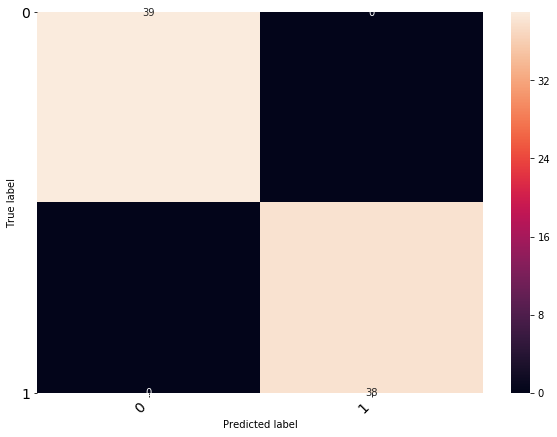

In [661]:
figsize = (10,7)
fontsize=14
cm=confusion_matrix(test_y,y_pred10)
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('consufion_matrix.png', dpi=100)